In [1]:
# Imports, as always...
from os import makedirs, path
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import torch
from math import log

from torch.utils.data import Dataset, DataLoader

from torch.nn import Sequential, Linear, ReLU, Softmax
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn.functional import one_hot

from sklearn.svm import SVC

# Dimensionality reduction and projection imports.
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# Date and time information for file saving.
from datetime import datetime
current_date = datetime.now().strftime("%d-%m-%Y")
current_time = datetime.now().strftime("%H-%M-%S")

# Script imports.
from dataset import load_dataset, load_flipped_dataset, PyTorchDataset

# Graphical imports.
import matplotlib.pyplot as plt
import seaborn as sns

# Styling.
palette = 'deep'
sns.set_theme(style='darkgrid', palette=palette)

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Random seeds.
torch.manual_seed(42)
np.random.seed(42)

In [3]:
dataset_path = 'martina/data/walkerDataset/all-dataset-1000.npz'
machines = [
    'ibmq_athens', 'ibmq_casablanca', 'ibmq_lima', 'ibmq_quito', 'ibmq_santiago', 'ibmq_5_yorktown'
]
machine_names = [ms.split('_')[-1].capitalize() for ms in machines]

# Fingerprint Classification

This notebook aims to replicate and advance the approaches to classification in [Martina et al. (2021)](https://arxiv.org/pdf/2109.11405), in which an SVM is used to binarily classify whether a given classical measurement was or was not produced by a given quantum circuit.

This is a simple task which, when taken together with their *very* small circuit, yields for near perfect accuracy. Here, we will complicate things to push the capability of the models to investigate more thoroughly what may or may not be possible with regard to classifying the membership of a quantum state to a quantum device by its "noise fingerprint". 

The ideas fitting into the work of this notebook are as follows:
- *Multi-class classification*. Using the data produced by Martina et al. (2021), can we present a multi-class prediction model that is not given any bias towards any particular model -- given a measurement of a quantum state, which device produced it?
- *Larger/deeper circuits*. How does the performance degrade as the number of qubits increases, or as the circuit depth increases?
- *Noise severity analysis*. Under which severities/forms of noise is performance best? Ideally, we can produce a visualisation of performance (e.g. accuracy) vs. noise intensity/severity. We might expect poor performance with little/no noise (not enough distinguishing information between membership classes), good performance with moderate noise, then poor performance again with large amounts of noise (too much randomness).

For clarity, 'membership to a quantum device' in this context refers to 'being produced by that device'.

## Visualising Distributions via Projection

It might be useful to get a visualisation for the probability distributions produced by the machines to look for any clear clustering or separability.

In [4]:
# Load in the all data (numpy).
xs, _, _, ys, _, _ = load_dataset(dataset_path, steps=[2], test_size=.0, val_size=.0, as_torch=False)

In [5]:
from sklearn.preprocessing import StandardScaler

# Preprocess the data, just for the giggles. Doesn't seem to make a difference.
xs_noise = xs - np.array([.0, .5, .25, .25])
xs_noise_scaled = StandardScaler().fit(xs_noise).transform(xs_noise)

In [6]:
# Instantiate and fit a 2D PCA to the distribution data (for the given measurement step).
pca = PCA(n_components=2)
xs_pca = pca.fit_transform(xs_noise_scaled)

In [7]:
# Likewise for t-SNE. This tends to take ~1.5 mins.
tsne = TSNE(n_components=2)
xs_tsne = tsne.fit_transform(xs_noise_scaled)

In [ ]:
# And UMAP. Note: Doesn't seem to be any better than t-SNE for these data.
#umap = UMAP(n_components=2)
#xs_umap = umap.fit_transform(xs)

In [8]:
# Create DataFrames for them (makes hue options easier).
pca_data = pd.DataFrame({'x' : xs_pca[:,0], 'y' : xs_pca[:,1], 'Machine' : ys.astype(int)})
tsne_data = pd.DataFrame({'x' : xs_tsne[:,0], 'y' : xs_tsne[:,1], 'Machine' : ys.astype(int)})
#umap_data = pd.DataFrame({'x' : xs_train_umap[:,0], 'y' : xs_train_umap[:,1], 'Machine' : ys_train.astype(int)})

# Replace machine indices with machine labels.
pca_data['Machine'].replace({i : machine for i, machine in enumerate(machine_names)}, inplace=True)
tsne_data['Machine'].replace({i : machine for i, machine in enumerate(machine_names)}, inplace=True)
#umap_data['Machine'].replace({i : machine for i, machine in enumerate(machines)}, inplace=True)

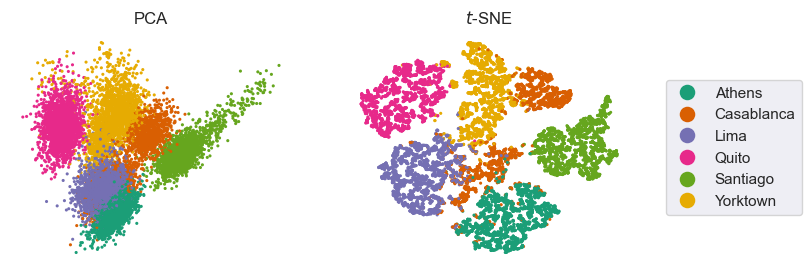

In [9]:
# Scatter plot the distributions in the reduced space (hue on machine).
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
palette = 'Dark2'
size = 5
alpha = 1
plot1 = sns.scatterplot(data=pca_data, x='x', y='y', hue='Machine', ax=ax1, s=size, linewidth=0, alpha=alpha, palette=palette)
plot2 = sns.scatterplot(data=tsne_data, x='x', y='y', hue='Machine', ax=ax2, s=size, linewidth=0, alpha=alpha, palette=palette)

# Beautification.
ax1.set_title('PCA')
ax2.set_title('$t$-SNE')

ax1.set_axis_off()
ax2.set_axis_off()

ax1.get_legend().remove()
legend = ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), markerscale=5)
legend._legend_box.align = "left"

#plt.savefig('./figures/martina-data-visualisation.pdf', bbox_inches='tight')

## Multi-class Classification

Given the measurement of a quantum state, what is the probability distribution over the set of devices (for the likelihood of membership), and subsequently which device is most likely to have produced the state?

The paper has two considerations for the input: (1) considering measurement outcomes at a single measurement step $k\in[1,\dots,9]$; and (2) concatenating all measurement outcomes in an ordered series $1,\dots,k$. Since the circuit is supposedly regenerated and then measured independently for each measurement step $k$, the only tangible difference between them is *time*. This is the point, actually -- the elements of the ordered series are independent of one another, yet ordered in time. 

### Ideas for Single-measurement

We'll define a model then train it to classify a given probability distribution as belonging to one of the machines. We'll train on each of the $k$ to obtain $k$ models that have learnt to discriminate distributions by machine membership at each time step. Then we can use each of these models to test on each time step too, giving that we will yield $k$ accuracy scores per model -- how well does each model discriminate at a given time step, considering the time step it was trained in. 

If we find that models are only really capable of classifying in or very near the time step they were trained in, then we are discovering that time-ordered series of noise are necessary to distinguish machines. This was the broad conclusion of the paper, but their method was not as direct as this (for whatever reason). On the other hand, having a model trained at the $k$-th step being able to classify quite well at the ($k+k')$-th for some $k'\gg0$ tells us that there is enough information in a slice of time to understand the inherent difference between the noise being produced by machines -- time-dependent or otherwise.

Another thing that might be interesting is to train a model with *all* data with no regard to time. This may be considered a brute-force version of the aforementioned test for time-dependence, but I think this might lead to a model capable of doing well at time steps it has never seen. For the sake of this last point, we might like to only train on the first few time steps (say 5) and evaluate on the final time step (i.e. 9) to allow for some distance between train and test sets.

Finally, we may also find interesting resutls training a model to discriminate *the time step* rather than the machine. That is, given a probability distribution from a single machine, can we classify the time step in which it was generated. We might then find use for this classify as a "selector" of sorts for choosing better architectural choice later on (e.g. if we have $k$ different classifiers for each time step as suggested above, then this model could be used to decide which to use given an unknown state).

### Training and testing within a single time step

Here we train a model to classify a given probability distribution, taken from the $k$-th measurement step, as belonging to one of the given machines. To test performance, we evaluate classification accuracy on  probability distributions taken from the same measurement step only -- model's trained on the $k$-th measurement step are *only* tested on samples from this step.

#### Multi-layer Perceptron (MLP)

In [11]:
# Function to perform a single training step (i.e. one epoch).
def training_step(model, loader, optimiser, loss_fn):
    # Use train mode.
    model.train()
    
    # Track the running loss and accuracy.
    running_loss = 0
    running_acc = 0
    
    # Iterate over the loader (if verbose is true, give a progress bar).
    for xs, ys_true in loader:
        # Zero gradients.
        optimiser.zero_grad()
        
        # Predict labels.
        ys_pred = model(xs)
        
        # Compute loss (adding to the running loss) and calculate gradients.
        loss = loss_fn(ys_pred, one_hot(ys_true.to(int), num_classes=ys_pred.shape[-1]).to(float))
        running_loss += loss.item()
        loss.backward()
        
        # Hardmax to get predicted class and compute accuracy.
        ys_pred_hardmax = torch.argmax(ys_pred, dim=1)
        running_acc += torch.sum(ys_pred_hardmax == ys_true).item()
        
        # Adjust weights.
        optimiser.step()
        
    # Return the average loss and accuracy over the epoch.
    return running_loss / len(loader), running_acc / len(loader.dataset)

# Function to evaluate with the given loader (i.e. validation/testing).
def evaluate(model, loader, loss_fn):
    # Use evaluation mode.
    model.eval()
    
    # Track the running loss and accuracy.
    running_loss = 0
    running_acc = 0
    
    # For evaluation, we do not track gradients.
    with torch.no_grad():
        # Iterate over the loader (if verbose is true, give a progress bar).
        for xs, ys_true in loader:
            # Predict labels.
            ys_pred = model(xs)
            
            # Compute loss (adding to the running loss).
            running_loss += loss_fn(ys_pred, one_hot(ys_true.to(int), num_classes=ys_pred.shape[-1]).to(float)).item()
            
            # Hardmax to get predicted class and compute accuracy.
            ys_pred_hardmax = torch.argmax(ys_pred, dim=1)
            running_acc += torch.sum(ys_pred_hardmax == ys_true).item()
            
    # Return the average loss and accuracy over the loader.
    return running_loss / len(loader), running_acc / len(loader.dataset)

# Function to perform a full training routine.
def train(model, train_loader, val_loader, n_epochs, lr=1e-3, weight_decay=.0, verbose=False, save_dir=None, save_file_name='model-dict'):
    # Create the save directory.
    if save_dir: makedirs(save_dir, exist_ok=True)
    
    # Set up an optimiser and loss function.
    optimiser = Adam(params=model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = CrossEntropyLoss()
    
    # Track the best validation loss so that we may return to the best weights on termination.
    best_val_loss = np.inf
    best_state = model.state_dict()
    
    # Remember the training statistics, just in case someone feels like plotting it.
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    
    for epoch_idx in (tqdm(np.arange(1, n_epochs + 1), desc='Top-level training') if verbose else np.arange(1, n_epochs + 1)):
        # Train the model.
        train_loss, train_acc = training_step(model, train_loader, optimiser, loss_fn)
        val_loss, val_acc = evaluate(model, val_loader, loss_fn)
        
        # Store those stats.
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update the best validation loss and remember the model's state.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
            
            # Save the model (if a save path has been given).
            if save_dir: torch.save(best_state, path.join(save_dir, f'{save_file_name}.pt'))
        
        # Print the stats (if verbose).
        if verbose:
            print(f'Epoch {epoch_idx:03d}: train loss - {train_loss:.3f}, val loss - {val_loss:.3f}, train acc - {train_acc:.3f}, val acc - {val_acc:.3f}')
            
    # Restore the best model in validation.
    model.load_state_dict(best_state)
            
    # Return the stats.
    return train_losses, train_accs, val_losses, val_accs

In [12]:
# Load in the data as Dataloaders.
train_dataloader, val_dataloader, _ = load_dataset(dataset_path, steps=[2], test_size=.25, val_size=.15,  shuffle=True, as_torch=True, batch_size=64)

# Generate and train a model.
hidden_size = 128
mlp_model = Sequential(
    Linear(4, hidden_size), ReLU(),
    Linear(hidden_size, hidden_size), ReLU(),
    Linear(hidden_size, len(machines)),
    #Softmax()
)
train_losses, train_accs, val_losses, val_accs = train(mlp_model, train_dataloader, val_dataloader, n_epochs=40, lr=1e-3, verbose=True)

Top-level training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 001: train loss - 1.642, val loss - 1.313, train acc - 0.499, val acc - 0.699
Epoch 002: train loss - 0.960, val loss - 0.686, train acc - 0.777, val acc - 0.845
Epoch 003: train loss - 0.564, val loss - 0.483, train acc - 0.864, val acc - 0.863
Epoch 004: train loss - 0.408, val loss - 0.360, train acc - 0.886, val acc - 0.890
Epoch 005: train loss - 0.331, val loss - 0.298, train acc - 0.896, val acc - 0.905
Epoch 006: train loss - 0.282, val loss - 0.264, train acc - 0.910, val acc - 0.918
Epoch 007: train loss - 0.250, val loss - 0.238, train acc - 0.919, val acc - 0.928
Epoch 008: train loss - 0.232, val loss - 0.225, train acc - 0.922, val acc - 0.924
Epoch 009: train loss - 0.211, val loss - 0.190, train acc - 0.931, val acc - 0.941
Epoch 010: train loss - 0.195, val loss - 0.189, train acc - 0.934, val acc - 0.944
Epoch 011: train loss - 0.183, val loss - 0.182, train acc - 0.936, val acc - 0.944
Epoch 012: train loss - 0.175, val loss - 0.156, train acc - 0.939, val acc 

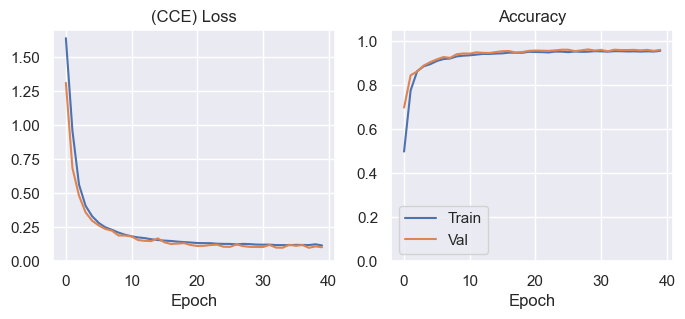

In [21]:
# Set up a figure and axes.
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(8, 3))

# Plot the stats.
epochs = np.arange(len(train_losses))
sns.lineplot(x=epochs, y=train_losses, ax=ax_loss)
sns.lineplot(x=epochs, y=val_losses, ax=ax_loss)
sns.lineplot(x=epochs, y=train_accs, ax=ax_acc, label='Train')
sns.lineplot(x=epochs, y=val_accs, ax=ax_acc, label='Val')

# Beautification.
ax_loss.set_title('(CCE) Loss')
ax_loss.set_xlabel('Epoch')

ax_acc.set_title('Accuracy')
ax_acc.set_xlabel('Epoch')

ax_loss.set_ylim(0, 1.7)
ax_acc.set_ylim(0, 1.05)

plt.show()

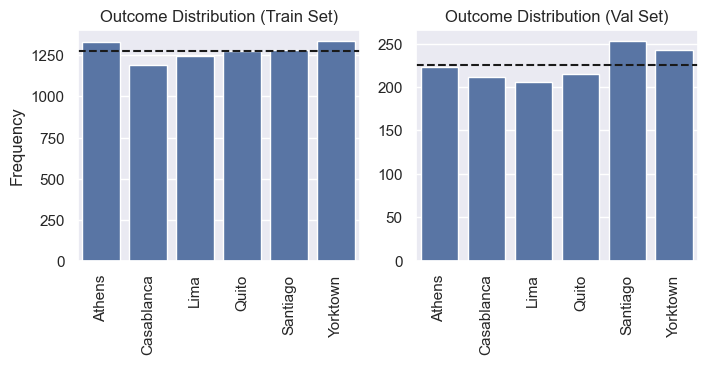

In [24]:
# Load in the train and val sets.
xs_train, xs_val, _, ys_train, ys_val, _ = load_dataset(dataset_path, steps=[2], test_size=.25, val_size=.15, as_torch=False)

# Checking distribution of outputs (e.g. to see whether the model has any bias).
outcomes_train = torch.argmax(mlp_model(torch.tensor(xs_train)), dim=1)
outcome_frequencies_train = np.unique(outcomes_train, return_counts=True)
outcomes_val = torch.argmax(mlp_model(torch.tensor(xs_val)), dim=1)
outcome_frequencies_val = np.unique(outcomes_val, return_counts=True)

# Plotting.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
sns.barplot(x=machines, y=outcome_frequencies_train[1], ax=ax1)
sns.barplot(x=machines, y=outcome_frequencies_val[1], ax=ax2)

# True frequency (for all machines is 2000).
ax1.axhline(xs_train.shape[0] / len(machines), color='k', linestyle='--')
ax2.axhline(xs_val.shape[0] / len(machines), color='k', linestyle='--')

# Beautifying.
ax1.set_title('Outcome Distribution (Train Set)')
ax2.set_title('Outcome Distribution (Val Set)')
ax1.set_ylabel('Frequency')
ax1.set_xticklabels(machine_names, rotation=90)
ax2.set_xticklabels(machine_names, rotation=90)

plt.show()

In [100]:
# Train a classifier for each measurement step.
models = {}
stats = {}
for step in tqdm(range(0, 9), desc='Training models'):
    # Data.
    train_dataloader, val_dataloader, _ = load_dataset(dataset_path, steps=[step], test_size=.25, val_size=.15,  shuffle=True, as_torch=True, batch_size=64)
    
    # Generate and train a model.
    hidden_size = 64
    mlp_model = Sequential(
        Linear(4, hidden_size), ReLU(),
        Linear(hidden_size, hidden_size), ReLU(),
        Linear(hidden_size, len(machines)),
        #Softmax()
    )
    train_losses, train_accs, val_losses, val_accs = train(mlp_model, train_dataloader, val_dataloader, n_epochs=50, lr=1e-3, verbose=False, save_dir=f'./models/mlp/{current_date}/{current_time}', save_file_name=f'step-{step+1}')
    
    # Store the model and stats.
    models[step] = mlp_model
    stats[step] = np.array([train_losses, train_accs, val_losses, val_accs])

Training models:   0%|          | 0/9 [00:00<?, ?it/s]

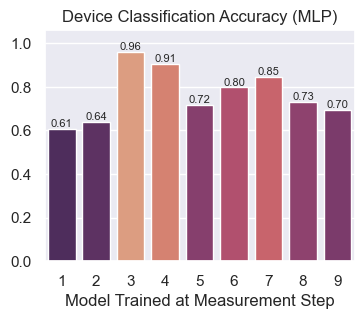

In [101]:
# Extract the best validation loss and accuracy from each model.
best_accs = [max(model_stats[3]) for model_stats in stats.values()]

# Colour palette.
def colors_from_values(values, palette_name):
    indices = np.round(((np.array(values) - .6) / .4) * 100).astype(np.int32)
    palette = sns.color_palette(palette_name, 100)
    return np.array(palette).take(indices, axis=0)

# Plot 'em.
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.barplot(x=np.arange(1, 10), y=best_accs, palette=colors_from_values(best_accs, 'flare_r'), ax=ax)

# Label the bars.
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=8)

# Beautification.
ax.set_title('Device Classification Accuracy (MLP)')
ax.set_xlabel('Model Trained at Measurement Step')
ax.set_ylim(0, 1.06)

plt.savefig('./figures/mlp/single-measurement-training/performance-by-measurement-step.pdf', bbox_inches='tight')

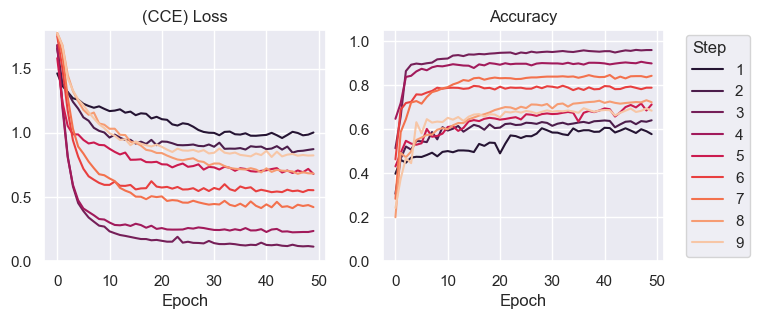

In [58]:
# Set up a figure and axes.
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(8, 3))

# Plot the stats for all models.
epochs = np.arange(len(train_losses))
palette = sns.color_palette('rocket', len(stats.keys()))
for i, model_stats in enumerate(stats.values()):
    sns.lineplot(x=epochs, y=model_stats[2], ax=ax_loss, color=palette[i])
    sns.lineplot(x=epochs, y=model_stats[3], ax=ax_acc, label=f'{i+1}', color=palette[i])

# Beautification.
ax_loss.set_title('(CCE) Loss')
ax_loss.set_xlabel('Epoch')
ax_loss.set_ylim(0, 1.8)

ax_acc.set_title('Accuracy')
ax_acc.set_xlabel('Epoch')
ax_acc.set_ylim(0, 1.05)

legend = ax_acc.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title='Step')
legend._legend_box.align = "left"

plt.savefig('./figures/mlp/single-measurement-training/training-curves-by-measurement-step.pdf', bbox_inches='tight')

In [60]:
# For each model, evaluate on each time step to understand its generality.
accs = {i : [] for i in models.keys()}
for i, model in tqdm(models.items(), desc=f'Evaluating models'):
    for step in range(9):
        # Data
        _, _, test_dataloader = load_dataset(dataset_path, steps=[step], test_size=.25, val_size=.15,  shuffle=True, as_torch=True, batch_size=64)
        
        # Evaluate the model on these data.
        loss_fn = CrossEntropyLoss()
        accs[i].append(evaluate(model, test_dataloader, loss_fn)[1])

Evaluating models:   0%|          | 0/9 [00:00<?, ?it/s]

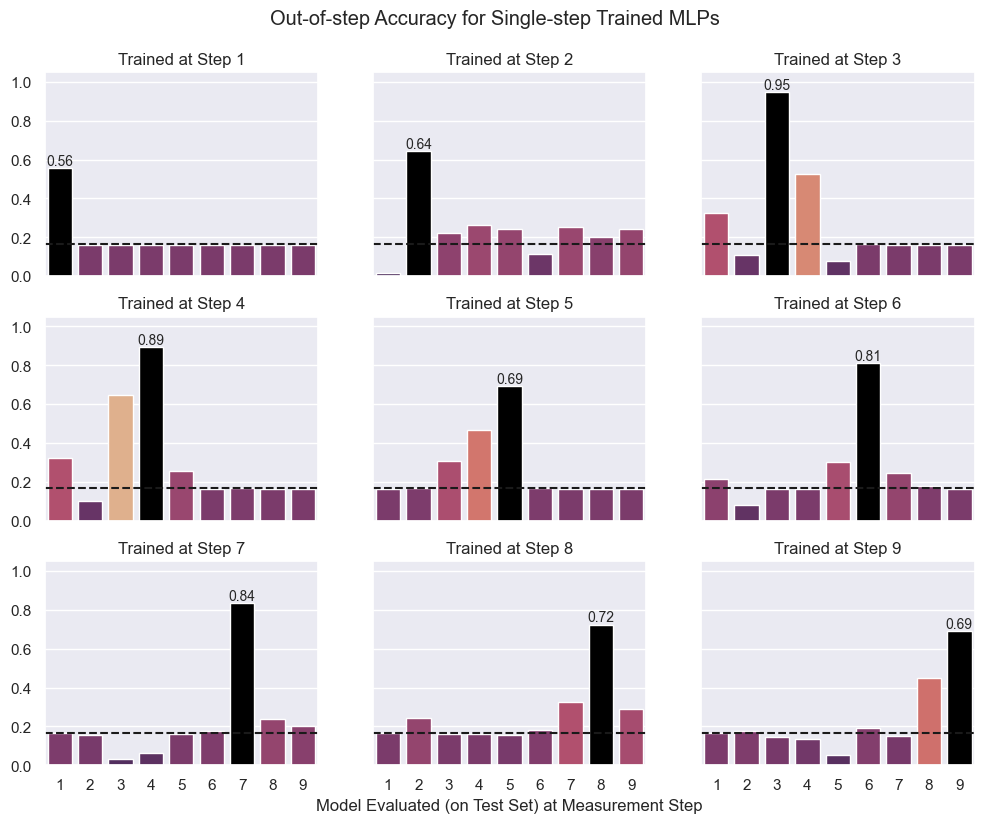

In [88]:
# Create a grid of bar charts showing the performance of each model on each measurement step.
fig, axes = plt.subplots(3, 3, figsize=(4*3, 3*3), sharey='row', sharex='col')

# Best out-of-step accuracy.
max_out_of_step_acc = max([np.sort(acc_list)[-2] for acc_list in accs.values()])

# Colour palette.
def colors_from_values(values, palette_name, max):
    indices = np.round((np.array(values) / max) * 100).astype(np.int32) - 1
    indices[indices > 100] = 0
    palette = sns.color_palette(palette_name, 100)
    return np.array(palette).take(indices, axis=0)

# Plot bars.
for i, ax in enumerate(axes.flatten()):
    ax.set_title(f'Trained at Step {i+1}')
    
    # Set the i-th bar (the measurement step this model was trained on) to be black.
    palette = colors_from_values(accs[i], 'flare_r', max=max_out_of_step_acc)
    palette[i] = [.0, .0, .0]
    
    sns.barplot(x=np.arange(1, 10), y=accs[i], ax=ax, palette=palette)
    ax.bar_label(ax.containers[i], fmt='%.2f', fontsize=10)
    
    # Add a dashed line on the performance achieved by random guessing.
    ax.axhline(1/len(machines), color='k', linestyle='--')
    
# Beautification.
fig.suptitle('Out-of-step Accuracy for Single-step Trained MLPs', y=.95)
axes[0][0].set_ylim(0, 1.05)
axes[1][0].set_ylim(0, 1.05)
axes[2][0].set_ylim(0, 1.05)
axes[2][1].set_xlabel('Model Evaluated (on Test Set) at Measurement Step')

plt.savefig('./figures/mlp/single-measurement-training/performance-across-all-measurement-steps.pdf', bbox_inches='tight')

#### Support Vector Machine (SVM)

In [102]:
# Build an SVM for each measurement step.
models = {}
stats = {}
for step in tqdm(range(9), desc='Fitting SVMs'):
    # Data.
    xs_train, xs_val, _, ys_train, ys_val, _ = load_dataset(dataset_path, steps=[step], test_size=.25, val_size=.15, as_torch=False)
    
    # Define and fit a classifier on the training data.
    svm_model = SVC(kernel='rbf', decision_function_shape='ovr').fit(xs_train, ys_train)
    
    # Make predictions for the validation set.
    ys_train_pred = svm_model.predict(xs_train)
    ys_val_pred = svm_model.predict(xs_val)
    
    # Calculate accuracy.
    eps = 1e-3
    train_acc = sum(ys_train == ys_train_pred) / ys_train.shape[0]
    val_acc = sum(ys_val == ys_val_pred) / ys_val.shape[0]
    
    # Remember the model and stats.
    models[step] = svm_model
    stats[step] = [train_acc, val_acc]

Fitting SVMs:   0%|          | 0/9 [00:00<?, ?it/s]

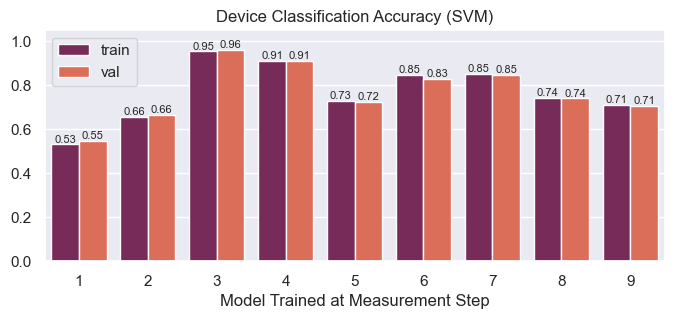

In [103]:
# Put the data into a DataFrame -- makes it easy to do grouped bar plots.
svm_data = pd.DataFrame({
    'Measurement Step' : np.array(list(stats.keys()) * 2) + 1,
    'Accuracy' : [x for x, _ in stats.values()] + [x for _, x in stats.values()],
    'Dataset' : ['train'] * len(stats) + ['val'] * len(stats)
})

# Bar plot them.
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
sns.barplot(data=svm_data, x='Measurement Step', y='Accuracy', hue='Dataset', palette='rocket', ax=ax)

# Label the bars.
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=8)

# Beautification.
ax.set_title('Device Classification Accuracy (SVM)')
ax.set_ylim(0, 1.05)
ax.legend(loc='upper left')
ax.set_ylabel('')
ax.set_xlabel('Model Trained at Measurement Step')

plt.savefig('./figures/svm/single-measurement-training/performance-by-measurement-step.pdf', bbox_inches='tight')

In [104]:
# For each model, evaluate on each time step to understand its generality.
accs = {i : [] for i in models.keys()}
for i, model in tqdm(models.items(), desc=f'Evaluating models'):
    for step in range(9):       
        # Data.
        _, _, xs_test, _, _, ys_test = load_dataset(dataset_path, steps=[step], test_size=.25, val_size=.15, as_torch=False)
        
        # Evaluate the model at this measurement step.
        ys_pred = model.predict(xs_test)
        accs[i].append(sum(ys_pred == ys_test) / len(ys_test))

Evaluating models:   0%|          | 0/9 [00:00<?, ?it/s]

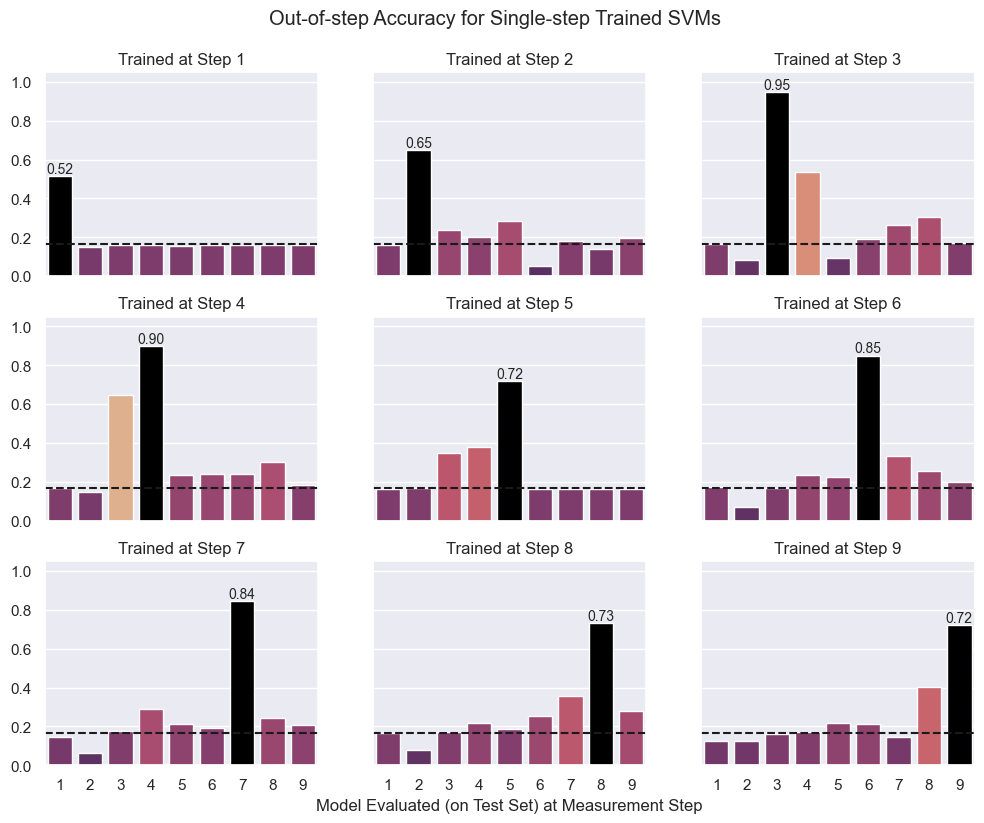

In [112]:
# Create a grid of bar charts showing the performance of each model on each measurement step.
fig, axes = plt.subplots(3, 3, figsize=(4*3, 3*3), sharey='row', sharex='col')

# Best out-of-step accuracy.
max_out_of_step_acc = max([np.sort(acc_list)[-2] for acc_list in accs.values()])

# Colour palette.
def colors_from_values(values, palette_name, max):
    indices = np.round((np.array(values) / max) * 100).astype(np.int32)
    indices[indices >= 100] = 99
    palette = sns.color_palette(palette_name, 100)
    return np.array(palette).take(indices, axis=0)

# Plot bars.
for i, ax in enumerate(axes.flatten()):
    ax.set_title(f'Trained at Step {i+1}')
    
    # Set the i-th bar (the measurement step this model was trained on) to be black.
    palette = colors_from_values(accs[i], 'flare_r', max=max_out_of_step_acc)
    palette[i] = [.0, .0, .0]
    
    sns.barplot(x=np.arange(1, 10), y=accs[i], ax=ax, palette=palette)
    ax.bar_label(ax.containers[i], fmt='%.2f', fontsize=10)
    
    # Add a dashed line on the performance achieved by random guessing.
    ax.axhline(1/len(machines), color='k', linestyle='--')
    
fig.suptitle('Out-of-step Accuracy for Single-step Trained SVMs', y=.95)
axes[0][0].set_ylim(0, 1.05)
axes[1][0].set_ylim(0, 1.05)
axes[2][0].set_ylim(0, 1.05)
axes[2][1].set_xlabel('Model Evaluated (on Test Set) at Measurement Step')

plt.savefig('./figures/svm/single-measurement-training/performance-across-all-measurement-steps.pdf', bbox_inches='tight')

## Measurement Step Classification

Now we turn the task on its head! Given a probability distribution (and possibly the machine that produced it), which measurement step does it belong to? 

This produces a model that is in some sense able to understand *how* noisy the state is, assuming that the $(k+1)$-th step is at least as noisy as the $k$-th step. Of course, that assumption may not be true, in which case the model is one that characterises noise more generally.

### Another visualisation, but with measurement step labels

In [ ]:
# Load data. Using all measurement steps is a LOT of data, so let's not use so much just yet.
xs, _, _, _, _, _, ys, _, _ = load_flipped_dataset(dataset_path, steps=np.arange(3), test_size=.0, val_size=.0, as_torch=False)

# Instantiate and fit a 2D PCA to the distribution data (for the given measurement step).
pca = PCA(n_components=2)
xs_pca = pca.fit_transform(xs)

# Likewise for t-SNE
tsne = TSNE(n_components=2)
xs_tsne = tsne.fit_transform(xs)

# Create DataFrames for them (makes hue options easier).
pca_data = pd.DataFrame({'x': xs_pca[:, 0], 'y': xs_pca[:, 1], 'Measurement Step': ys.astype(int)})
tsne_data = pd.DataFrame({'x': xs_tsne[:, 0], 'y': xs_tsne[:, 1], 'Measurement Step': ys.astype(int)})

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
palette = 'Dark2'
size = 5
alpha = .5
plot1 = sns.scatterplot(data=pca_data, x='x', y='y', hue='Measurement Step', ax=ax1, s=size, linewidth=0, alpha=alpha, palette=palette)
plot2 = sns.scatterplot(data=tsne_data, x='x', y='y', hue='Measurement Step', ax=ax2, s=size, linewidth=0, alpha=alpha, palette=palette)

# Beautification.
ax1.set_title('PCA')
ax2.set_title('$t$-SNE')

ax1.set_axis_off()
ax2.set_axis_off()

ax1.get_legend().remove()
legend = ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), markerscale=5, title='Step')
legend._legend_box.align = "left"

plt.savefig('./figures/martina-data-visualisation-by-step.pdf', bbox_inches='tight')

In [ ]:
# Selecting the data for only one machine.
xs, _, _, machine_indices, _, _, ys, _, _ = load_flipped_dataset(dataset_path, steps=np.arange(9), test_size=.0, val_size=.0, as_torch=False)

# The machine we'd like to use.
machine_idx = 0

# Instantiate and fit a 2D PCA to the distribution data (for the given measurement step).
pca = PCA(n_components=2)
xs_pca = pca.fit_transform(xs[machine_indices == machine_idx])

# Likewise for t-SNE
tsne = TSNE(n_components=2)
xs_tsne = tsne.fit_transform(xs[machine_indices == machine_idx])

# Create DataFrames for them (makes hue options easier).
pca_data = pd.DataFrame({'x': xs_pca[:, 0], 'y': xs_pca[:, 1], 'Measurement Step': ys[machine_indices == machine_idx].astype(int)})
tsne_data = pd.DataFrame({'x': xs_tsne[:, 0], 'y': xs_tsne[:, 1], 'Measurement Step': ys[machine_indices == machine_idx].astype(int)})

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
palette = 'Dark2'
size = 5
alpha = 1
plot1 = sns.scatterplot(data=pca_data, x='x', y='y', hue='Measurement Step', ax=ax1, s=size, linewidth=0, alpha=alpha, palette=palette)
plot2 = sns.scatterplot(data=tsne_data, x='x', y='y', hue='Measurement Step', ax=ax2, s=size, linewidth=0, alpha=alpha, palette=palette)

# Beautification.
ax1.set_title('PCA')
ax2.set_title('$t$-SNE')

ax1.set_axis_off()
ax2.set_axis_off()

ax1.get_legend().remove()
legend = ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), markerscale=5, title='Step')
legend._legend_box.align = "left"

plt.savefig('./figures/martina-data-visualisation-by-step-one-machine.pdf', bbox_inches='tight')

### Training *without* machine indices

This is the classification of measurement step from probability distribution alone -- the classifier does not know which machine produced the distribution, nor does it care.

In [124]:
# Load in the data as numpy arrays.
n_steps = 9
xs_train, xs_val, _, _, _, _, ys_train, ys_val, _ = load_flipped_dataset(dataset_path, steps=np.arange(n_steps), test_size=.25, val_size=.15, shuffle=True, as_torch=False)

# Stick it in a couple Dataloaders. We do this manually so as not to rewrite the train steps -- I'm being lazy.
batch_size = 64
train_dataloader = DataLoader(PyTorchDataset(xs_train, ys_train), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(PyTorchDataset(xs_val, ys_val), batch_size=batch_size, shuffle=True)

# Generate and train a model.
hidden_size = 128
mlp_model = Sequential(
    Linear(4, hidden_size), ReLU(),
    Linear(hidden_size, hidden_size), ReLU(),
    Linear(hidden_size, n_steps),
    #Softmax()
)
train_losses, train_accs, val_losses, val_accs = train(mlp_model, train_dataloader, val_dataloader, n_epochs=40, lr=1e-4, verbose=True)

Top-level training:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 001: train loss - 1.839, val loss - 1.405, train acc - 0.391, val acc - 0.535
Epoch 002: train loss - 1.215, val loss - 1.077, train acc - 0.599, val acc - 0.630
Epoch 003: train loss - 0.980, val loss - 0.895, train acc - 0.654, val acc - 0.689
Epoch 004: train loss - 0.844, val loss - 0.794, train acc - 0.690, val acc - 0.701
Epoch 005: train loss - 0.769, val loss - 0.735, train acc - 0.709, val acc - 0.715
Epoch 006: train loss - 0.724, val loss - 0.698, train acc - 0.721, val acc - 0.723
Epoch 007: train loss - 0.695, val loss - 0.673, train acc - 0.730, val acc - 0.732
Epoch 008: train loss - 0.674, val loss - 0.655, train acc - 0.737, val acc - 0.745
Epoch 009: train loss - 0.657, val loss - 0.637, train acc - 0.742, val acc - 0.744
Epoch 010: train loss - 0.643, val loss - 0.625, train acc - 0.749, val acc - 0.752
Epoch 011: train loss - 0.631, val loss - 0.614, train acc - 0.754, val acc - 0.761
Epoch 012: train loss - 0.621, val loss - 0.602, train acc - 0.759, val acc 

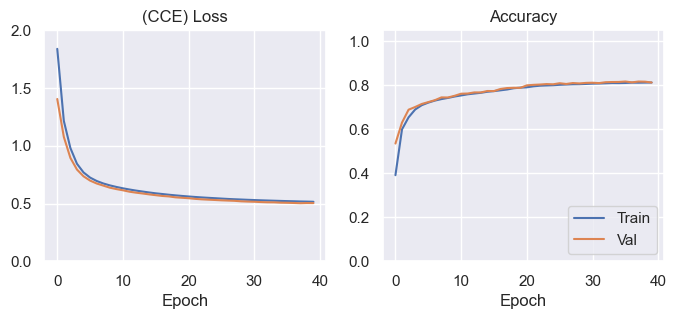

In [128]:
# Set up a figure and axes.
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(8, 3))

# Plot the stats.
epochs = np.arange(len(train_losses))
sns.lineplot(x=epochs, y=train_losses, ax=ax_loss)
sns.lineplot(x=epochs, y=val_losses, ax=ax_loss)
sns.lineplot(x=epochs, y=train_accs, ax=ax_acc, label='Train')
sns.lineplot(x=epochs, y=val_accs, ax=ax_acc, label='Val')

# Beautification.
ax_loss.set_title('(CCE) Loss')
ax_loss.set_xlabel('Epoch')

ax_acc.set_title('Accuracy')
ax_acc.set_xlabel('Epoch')

ax_loss.set_ylim(0, 2)
ax_acc.set_ylim(0, 1.05)

ax_acc.legend(loc='lower right')

plt.show()

In [8]:
# Now we train a classifier for each machine independently, like we did previously.
models = {}
stats = {}
for machine_idx in range(len(machines)):
    # Load in the data as numpy arrays.
    n_steps = 9
    xs_train, xs_val, _, machine_indices_train, machine_indices_val, _, ys_train, ys_val, _ = load_flipped_dataset(dataset_path, steps=np.arange(n_steps), test_size=.25, val_size=.15, shuffle=True, as_torch=False)
    
    # Filter to only the current machine.
    xs_train = xs_train[machine_indices_train == machine_idx]
    ys_train = ys_train[machine_indices_train == machine_idx]
    xs_val = xs_val[machine_indices_val == machine_idx]
    ys_val = ys_val[machine_indices_val == machine_idx]

    # Stick it in a couple Dataloaders. We do this manually so as not to rewrite the train steps -- I'm being lazy.
    batch_size = 64
    train_dataloader = DataLoader(PyTorchDataset(xs_train, ys_train), batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(PyTorchDataset(xs_val, ys_val), batch_size=batch_size, shuffle=True)
    
    # Generate and train a model.
    hidden_size = 128
    mlp_model = Sequential(
        Linear(4, hidden_size), ReLU(),
        Linear(hidden_size, hidden_size), ReLU(),
        Linear(hidden_size, n_steps),
        Softmax()
    )
    train_losses, train_accs, val_losses, val_accs = train(mlp_model, train_dataloader, val_dataloader, n_epochs=20, lr=1e-4, verbose=False)
    
    # Save the model and stats.
    models[machine_idx] = mlp_model
    stats[machine_idx] = [train_losses, train_accs, val_losses, val_accs]

Top-level training:   0%|          | 0/20 [00:00<?, ?it/s]

Top-level training:   0%|          | 0/20 [00:00<?, ?it/s]

Top-level training:   0%|          | 0/20 [00:00<?, ?it/s]

Top-level training:   0%|          | 0/20 [00:00<?, ?it/s]

Top-level training:   0%|          | 0/20 [00:00<?, ?it/s]

Top-level training:   0%|          | 0/20 [00:00<?, ?it/s]

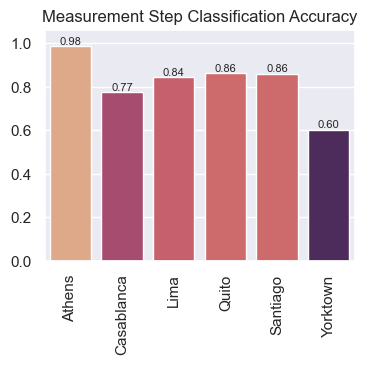

In [32]:
# Extract the best validation loss and accuracy from each model.
best_accs = [max(model_stats[3]) for model_stats in stats.values()]

# Colour palette.
def colors_from_values(values, palette_name):
    indices = np.round(((np.array(values) - .6) / .4) * 100).astype(np.int32)
    palette = sns.color_palette(palette_name, 100)
    return np.array(palette).take(indices, axis=0)

# Plot 'em.
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.barplot(x=machines, y=best_accs, palette=colors_from_values(best_accs, 'flare_r'), ax=ax)

# Label the bars.
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=8)

# Beautification.
ax.set_title('Measurement Step Classification Accuracy')
ax.set_ylim(0, 1.06)
ax.set_xticklabels([ms.split('_')[-1].capitalize() for ms in machines], rotation=90)

plt.savefig('./figures/mlp/single-measurement-training/step-classification-by-machine.pdf', bbox_inches='tight')

## Frankensteining for Blind Classification

Now suppose we are given an arbitrary sample without knowledge of either the machine or measurement step. The idea is that we can smoosh our two classifying models together to form one end-to-end pipeline that can be completely agnostic: employ the measurement step classifier to decide which device classifier to use, and in doing so identity both the measurement step and device for the distribution.

In [131]:
# Re-train the step classifier (because I forgot to save it).
n_steps = 9
batch_size = 64
hidden_size = 128

xs_train, xs_val, _, _, _, _, ys_train, ys_val, _ = load_flipped_dataset(dataset_path, steps=np.arange(n_steps), test_size=.25, val_size=.15, shuffle=True, as_torch=False)
train_dataloader = DataLoader(PyTorchDataset(xs_train, ys_train), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(PyTorchDataset(xs_val, ys_val), batch_size=batch_size, shuffle=True)
step_classifier = Sequential(
    Linear(4, hidden_size), ReLU(),
    Linear(hidden_size, hidden_size), ReLU(),
    Linear(hidden_size, n_steps)
)
_, _, _ ,_ = train(step_classifier, train_dataloader, val_dataloader, n_epochs=50, lr=1e-4, verbose=True, save_dir='./models/mlp/step-classifier')

Top-level training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 001: train loss - 1.839, val loss - 1.405, train acc - 0.391, val acc - 0.535
Epoch 002: train loss - 1.215, val loss - 1.077, train acc - 0.599, val acc - 0.630
Epoch 003: train loss - 0.980, val loss - 0.895, train acc - 0.654, val acc - 0.689
Epoch 004: train loss - 0.844, val loss - 0.794, train acc - 0.690, val acc - 0.701
Epoch 005: train loss - 0.769, val loss - 0.735, train acc - 0.709, val acc - 0.715
Epoch 006: train loss - 0.724, val loss - 0.698, train acc - 0.721, val acc - 0.723
Epoch 007: train loss - 0.695, val loss - 0.673, train acc - 0.730, val acc - 0.732
Epoch 008: train loss - 0.674, val loss - 0.655, train acc - 0.737, val acc - 0.745
Epoch 009: train loss - 0.657, val loss - 0.637, train acc - 0.742, val acc - 0.744
Epoch 010: train loss - 0.643, val loss - 0.625, train acc - 0.749, val acc - 0.752
Epoch 011: train loss - 0.631, val loss - 0.614, train acc - 0.754, val acc - 0.761
Epoch 012: train loss - 0.621, val loss - 0.602, train acc - 0.759, val acc 

In [177]:
# Function classifying a given xs 'blindly' using a given step classifier to choose between a set of device classifiers at a given directory.
def classify_blindly(xs, step_classifier, device_classifier_dir, hidden_size):
    # Make sure the step classifier is in evaluation mode.
    step_classifier.eval()
    
    # First we classify for measurement step.
    step_pred = step_classifier(xs)
    
    # Load in a device classifier according to the predicted step, and stick it in evaluation mode.
    device_classifier = Sequential(
        Linear(4, hidden_size), ReLU(),
        Linear(hidden_size, hidden_size), ReLU(),
        Linear(hidden_size, len(machines))
    )
    device_classifier.load_state_dict(torch.load(path.join(device_classifier_dir,f'step-{step_pred.argmax().item()+1}.pt')))
    device_classifier.eval()
    
    # And now we classify for device.
    machine_pred = device_classifier(xs)
    
    return step_pred, machine_pred

# Function to evaluate the Frankenstein-like classification pipeline.
def evaluate_blind_classifier(step_classifier, device_classifier_dir, loader, loss_fn):
    # Track the running loss and accuracy.
    machine_loss = 0
    step_loss = 0
    machine_acc = 0
    step_acc = 0
    
    # For evaluation, we do not track gradients.
    with torch.no_grad():
        # Iterate over the loader (if verbose is true, give a progress bar).
        for xs, machine_true, step_true in tqdm(loader, desc='Evaluating'):
            # Predict stuff.
            step_pred, machine_pred = classify_blindly(xs, step_classifier, device_classifier_dir, hidden_size=64)
            
            # Compute loss (adding to the running loss).
            machine_loss += loss_fn(machine_pred, one_hot(machine_true.to(int), num_classes=machine_pred.shape[-1]).to(float)).item()
            step_loss += loss_fn(step_pred, one_hot(step_true.to(int), num_classes=step_pred.shape[-1]).to(float)).item()
            
            # Hardmax to get predicted class and compute accuracy.
            step_pred_hardmax = torch.argmax(step_pred, dim=1)
            machine_pred_hardmax = torch.argmax(machine_pred, dim=1)
            step_acc += torch.sum(step_pred_hardmax == step_true).item()
            machine_acc += torch.sum(machine_pred_hardmax == machine_true).item()
            
    # Return the average loss and accuracy over the loader.
    return machine_loss / len(loader), step_loss / len(loader), machine_acc / len(loader.dataset), step_acc / len(loader.dataset)

In [180]:
# Let's have some blind dataloaders.
# These do have to be batch size of 1 because we cannot know the 
train_dataloader, val_dataloader, test_dataloader = load_flipped_dataset(dataset_path, steps=np.arange(9), test_size=.25, val_size=.15, shuffle=True, as_torch=True, batch_size=1)

# And let's see how we did.
train_stats = evaluate_blind_classifier(step_classifier, f'./models/mlp/{current_date}/{current_time}', train_dataloader, CrossEntropyLoss())
print('Train set...')
print(f'Device Classification: loss - {train_stats[0]:.3f}, acc - {train_stats[2]:.3f}')
print(f'Step Classification:   loss - {train_stats[1]:.3f}, acc - {train_stats[3]:.3f}\n')

val_stats = evaluate_blind_classifier(step_classifier, f'./models/mlp/{current_date}/{current_time}', val_dataloader, CrossEntropyLoss())
print('Validation set...')
print(f'Device Classification: loss - {val_stats[0]:.3f}, acc - {val_stats[2]:.3f}')
print(f'Step Classification:   loss - {val_stats[1]:.3f}, acc - {val_stats[3]:.3f}\n')

test_stats = evaluate_blind_classifier(step_classifier, f'./models/mlp/{current_date}/{current_time}', test_dataloader, CrossEntropyLoss())
print('Test set...')
print(f'Device Classification: loss - {test_stats[0]:.3f}, acc - {test_stats[2]:.3f}')
print(f'Step Classification:   loss - {test_stats[1]:.3f}, acc - {test_stats[3]:.3f}\n')

Evaluating:   0%|          | 0/68850 [00:00<?, ?it/s]

Train set...
Device Classification: loss - 1.138, acc - 0.667
Step Classification:   loss - 0.502, acc - 0.815


Evaluating:   0%|          | 0/12150 [00:00<?, ?it/s]

Validation set...
Device Classification: loss - 1.126, acc - 0.673
Step Classification:   loss - 0.489, acc - 0.818


Evaluating:   0%|          | 0/27000 [00:00<?, ?it/s]

Test set...
Device Classification: loss - 1.144, acc - 0.666
Step Classification:   loss - 0.497, acc - 0.813
